In [79]:
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import ast

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.cluster import KMeans

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer

from helper import plot_missing_values, replace_ids_with_titles

In [42]:
# Import the datasets 
tracks_echonest = pd.read_csv('data/tracks_echonest_titles.tsv', sep='\t')
tracks_spectral = pd.read_csv('data/tracks_spectral_titles.tsv', sep='\t')
genres = pd.read_csv('data/genres.csv', sep=',')

# tracks_spectral['genres'] = tracks_spectral['genres'].apply(ast.literal_eval)
# tracks_spectral['genres_all'] = tracks_spectral['genres_all'].apply(ast.literal_eval)
# # transfor genre ids to titles
# tracks_spectral = replace_ids_with_titles(tracks_spectral, 'genre_top', genres)
# tracks_spectral = replace_ids_with_titles(tracks_spectral, 'genres', genres)
# tracks_spectral = replace_ids_with_titles(tracks_spectral, 'genres_all', genres)

c:\Users\Chaima\Documents_local\3A\Supervised_Challenge\helper.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=na_pct.values, y=na_pct.index, palette='viridis')


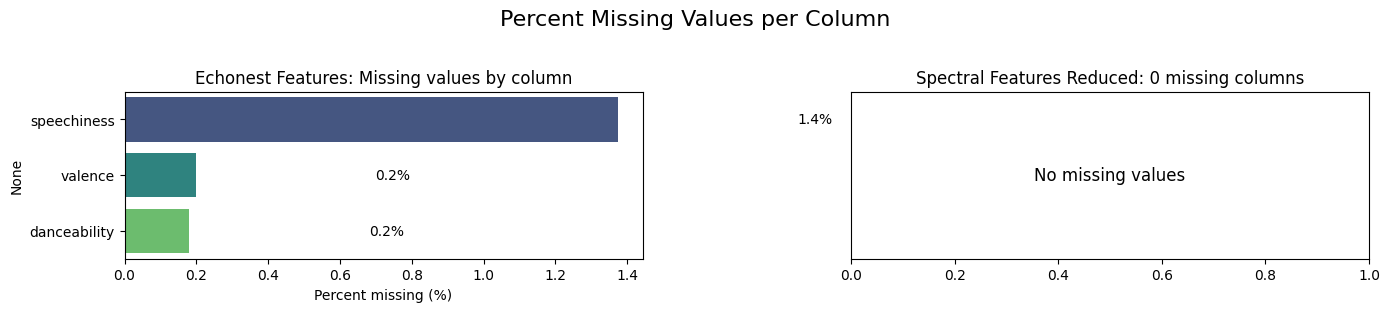

In [43]:
# Plot missing values in both datasets
datasets = {
    'Echonest Features': tracks_echonest,
    'Spectral Features Reduced': tracks_spectral
}

plot_missing_values(datasets)

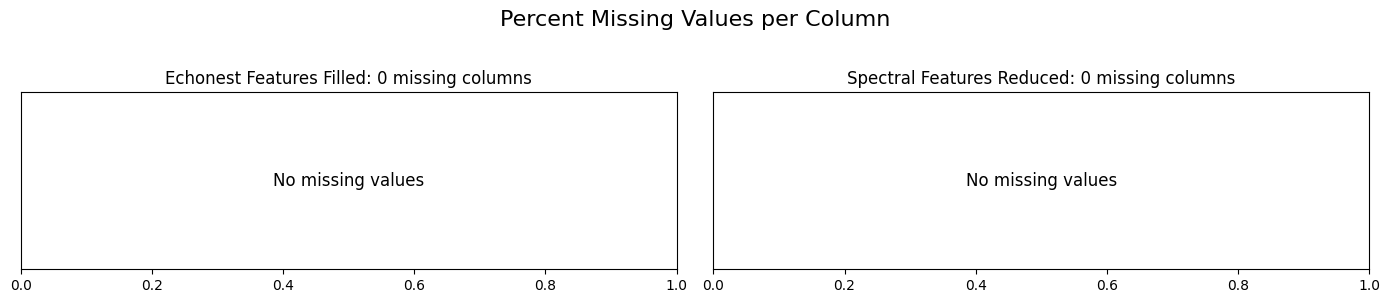

In [44]:
# remove missing values from tracks_echonest
df_spectral = tracks_spectral
df_echonest = tracks_echonest.dropna()
datasets = {
    'Echonest Features Filled': df_echonest,
    'Spectral Features Reduced': tracks_spectral
}
plot_missing_values(datasets)

In [45]:
print(f"Feature titles in tracks_echonest : {tracks_echonest.columns.tolist()}")

Feature titles in tracks_echonest : ['track_id', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'album_title', 'album_tracks', 'artist_latitude', 'artist_longitude', 'artist_name', 'duration', 'favorites', 'genre_top', 'genres', 'genres_all', 'interest', 'listens', 'title', 'spectral_bandwidth_kurtosis_01', 'spectral_bandwidth_max_01', 'spectral_bandwidth_mean_01', 'spectral_bandwidth_median_01', 'spectral_bandwidth_min_01', 'spectral_bandwidth_skew_01', 'spectral_bandwidth_std_01', 'spectral_centroid_kurtosis_01', 'spectral_centroid_max_01', 'spectral_centroid_mean_01', 'spectral_centroid_median_01', 'spectral_centroid_min_01', 'spectral_centroid_skew_01', 'spectral_centroid_std_01', 'spectral_rolloff_kurtosis_01', 'spectral_rolloff_max_01', 'spectral_rolloff_mean_01', 'spectral_rolloff_median_01', 'spectral_rolloff_min_01', 'spectral_rolloff_skew_01', 'spectral_rolloff_std_01', 'artist_location_unknown']


## Feature Classification for Genre Prediction (Task 1 & 2)

### 1. ID / Join-Only Columns  
**Drop as predictors**
- `track_id` — use only for merges; never include as a feature.

---

### 2. High-Cardinality Text  
**Drop for baseline; maybe use later with NLP**
- `title`
- `album_title`
- `artist_name`

(Too sparse/high-cardinality for simple audio-only baselines.)

---

### 3. Genre Labels / Taxonomy  
**Targets or auxiliary info (not numeric predictors)**
- `genre_top` — **main target**
- `genres`, `genres_all` — lists of tags; can be parsed or merged with `genres.csv` but raw strings are unusable as features.

---

### 4. Core Audio Predictors  
**Keep — main baseline features**
- `acousticness`
- `danceability`
- `energy`
- `instrumentalness`
- `liveness`
- `speechiness`
- `tempo`
- `valence`
- `duration`

(Standard “Spotify-like” features; strong predictors for genre.)

---

### 5. Popularity / Usage  
**Keep *only* if predicting popularity — otherwise drop (genre leakage risk)**
- `favorites`
- `interest`
- `listens`

(These often correlate with genre distribution → leakage.)

---

### 6. Location / Context  
**Optional (weak signal for pure audio genre)**
- `artist_latitude`
- `artist_longitude`
- `artist_location_unknown`
- `album_tracks`

---

### 7. Spectral Feature Block  
**Keep, but ideally reduce dimensionality**
- All `spectral_bandwidth_*`
- All `spectral_centroid_*`
- All `spectral_rolloff_*`

(Important for timbre/brightness but highly redundant → PCA or aggregation recommended.)

---

### ✔ Recommended Clean Baseline Feature Set  
For a strong yet simple **genre prediction baseline**:
- The 8–9 Spotify-like audio features  
- `duration`  
- One location dummy (optional)  
- A **reduced set** of spectral features (via PCA or summary statistics)  
- **Drop** IDs, text fields, and popularity metrics


In [46]:
# Drop the ID columns
df_echonest = df_echonest.drop(columns=['track_id'])
df_spectral = df_spectral.drop(columns=['track_id'])

# Drop artist location related features
df_echonest = df_echonest.drop(columns=['artist_latitude', 'artist_longitude', 'artist_location_unknown'])
df_spectral = df_spectral.drop(columns=['artist_latitude', 'artist_longitude', 'artist_location_unknown'])

In [47]:
# We re going to inspect colinearity in these groups of features 
core_audio_features = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration']
spectral_features = [col for col in df_spectral.columns if col.startswith('spectral_')]
popularity_features = ['favorites', 'interest', 'listens']

print(f"Core audio features: {core_audio_features}")
print(f"Spectral features: {spectral_features}")
print(f"Popularity features: {popularity_features}")
# print the rest of features execpt the above three groups
other_features = [col for col in df_echonest.columns if col not in core_audio_features + spectral_features + popularity_features]
print(f"Other features in df_echonest: {other_features}")
other_features_spectral = [col for col in df_spectral.columns if col not in core_audio_features + spectral_features + popularity_features]
print(f"Other features in df_spectral: {other_features_spectral}")

Core audio features: ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration']
Spectral features: ['spectral_bandwidth_kurtosis_01', 'spectral_bandwidth_max_01', 'spectral_bandwidth_mean_01', 'spectral_bandwidth_median_01', 'spectral_bandwidth_min_01', 'spectral_bandwidth_skew_01', 'spectral_bandwidth_std_01', 'spectral_centroid_kurtosis_01', 'spectral_centroid_max_01', 'spectral_centroid_mean_01', 'spectral_centroid_median_01', 'spectral_centroid_min_01', 'spectral_centroid_skew_01', 'spectral_centroid_std_01', 'spectral_rolloff_kurtosis_01', 'spectral_rolloff_max_01', 'spectral_rolloff_mean_01', 'spectral_rolloff_median_01', 'spectral_rolloff_min_01', 'spectral_rolloff_skew_01', 'spectral_rolloff_std_01']
Popularity features: ['favorites', 'interest', 'listens']
Other features in df_echonest: ['album_title', 'album_tracks', 'artist_name', 'genre_top', 'genres', 'genres_all', 'title']
Other features in df_spectral: ['albu

In [48]:
def plot_feature_correlation(df, feature_list, title="Correlation Matrix"):
    """
    Plots a correlation matrix for a given list of features in a DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing the features.
        feature_list (list): List of column names to include in the correlation matrix.
        title (str): Title of the plot.
    """
    corr = df[feature_list].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=False, fmt=".1f", cmap="coolwarm", square=True, linewidths=0.5)
    plt.title(title, fontsize=16)
    plt.show()

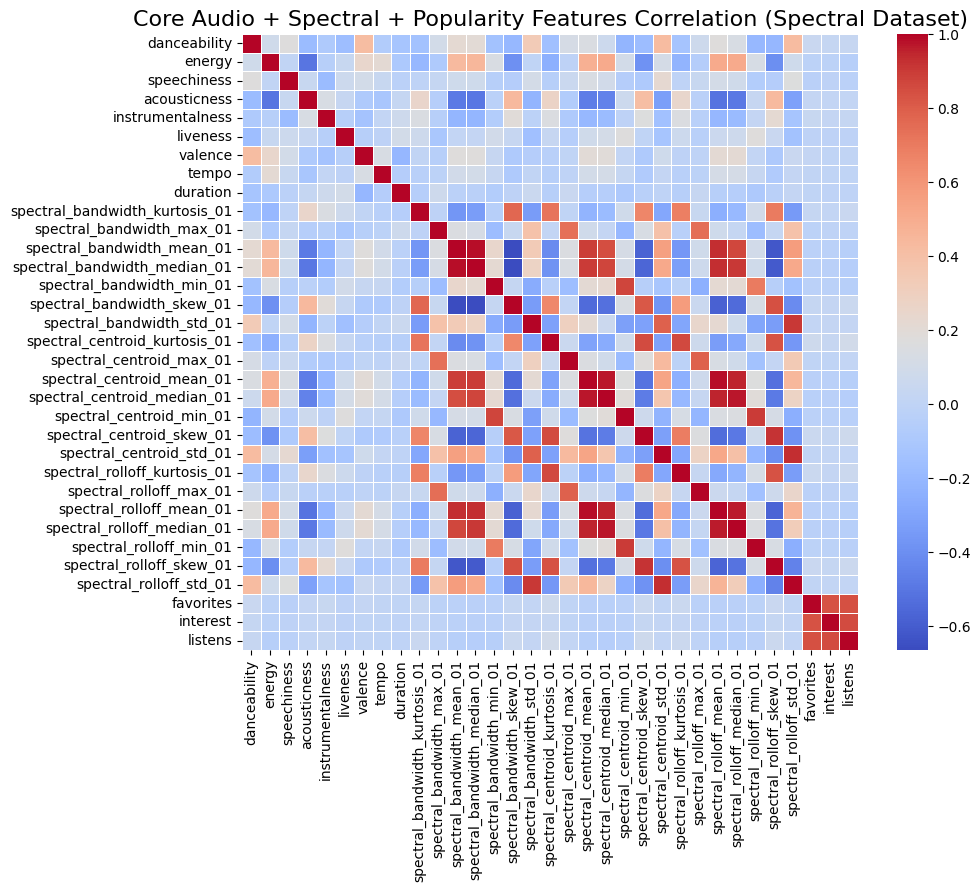

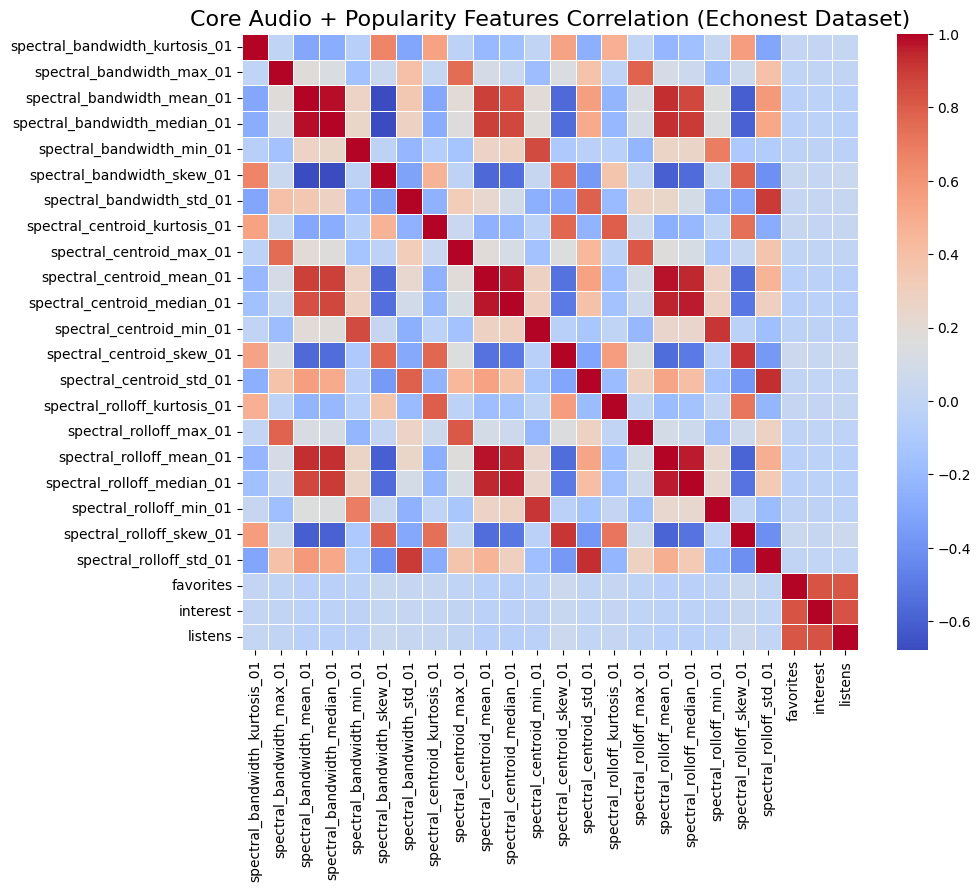

In [49]:
plot_feature_correlation(df_echonest, core_audio_features+spectral_features+popularity_features, title="Core Audio + Spectral + Popularity Features Correlation (Spectral Dataset)")
plot_feature_correlation(df_spectral, spectral_features+popularity_features, title="Core Audio + Popularity Features Correlation (Echonest Dataset)")

In [50]:
# We will use PCA on spectral features to reduce colinearity

def apply_pca(df, feature_list, n_components=None):
    """
    Applies PCA to a group of features.

    Parameters:
        df (pd.DataFrame): DataFrame containing the features.
        feature_list (list): List of columns to apply PCA on.
        n_components (int or None): Number of PCA components to keep. If None, keep all.

    Returns:
        pca (PCA object): Fitted PCA object.
        df_pca (pd.DataFrame): Transformed PCA components as DataFrame.
    """

    # strandardize the features before applying PCA
    scaler = StandardScaler()
    df[feature_list] = scaler.fit_transform(df[feature_list])
    
    pca = PCA(n_components=n_components)
    X = df[feature_list].values
    X_pca = pca.fit_transform(X)
    
    # Build a DataFrame with PCA components
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    df_pca = pd.DataFrame(X_pca, columns=component_names, index=df.index)
    
    return pca, df_pca

def plot_pca_correlations(df, feature_list, pca, df_pca, title="PCA vs Original Features Correlation"):
    """
    Plots correlation of each PCA component with the original features.

    Parameters:
        df (pd.DataFrame): Original DataFrame.
        feature_list (list): Original features used in PCA.
        pca (PCA object): Fitted PCA object.
        df_pca (pd.DataFrame): DataFrame containing PCA components.
        title (str): Title of the plot.
    """
    # Compute correlation of each PCA component with original features
    corr_matrix = pd.DataFrame(
        np.dot(df[feature_list].values.T, df_pca.values) / (len(df)-1),
        index=feature_list,
        columns=df_pca.columns
    )
    
    # Optional: normalize correlations between -1 and 1
    corr_matrix = corr_matrix / corr_matrix.abs().max()
    
    plt.figure(figsize=(12,8))
    sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(title, fontsize=16)
    plt.show()

def plot_pca_variance(pca, title="Explained Variance per PCA Component"):
    """
    Plots the explained variance ratio of each PCA component.

    Parameters:
        pca (PCA object): Fitted PCA object.
        title (str): Title of the plot.
    """
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = explained_variance.cumsum()
    
    plt.figure(figsize=(10,6))
    plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.6, label="Individual variance")
    plt.step(range(1, len(cumulative_variance)+1), cumulative_variance, where='mid', color='red', label="Cumulative variance")
    plt.xlabel("PCA Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title(title, fontsize=16)
    plt.xticks(range(1, len(explained_variance)+1))
    plt.legend()
    plt.show()




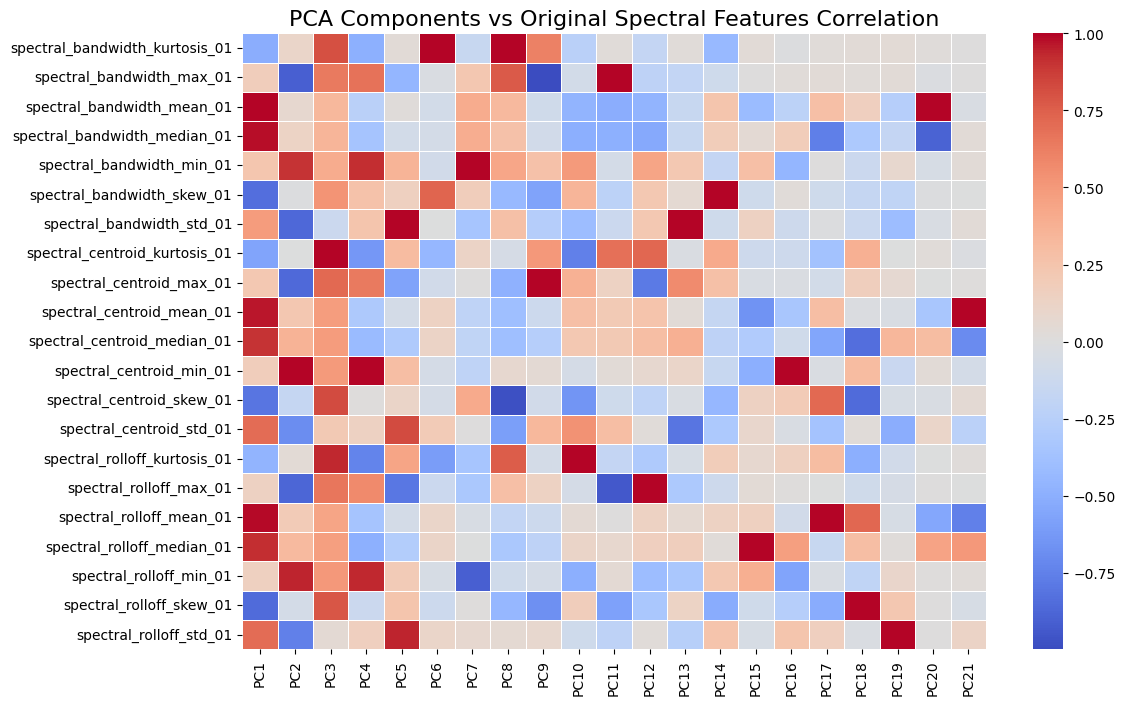

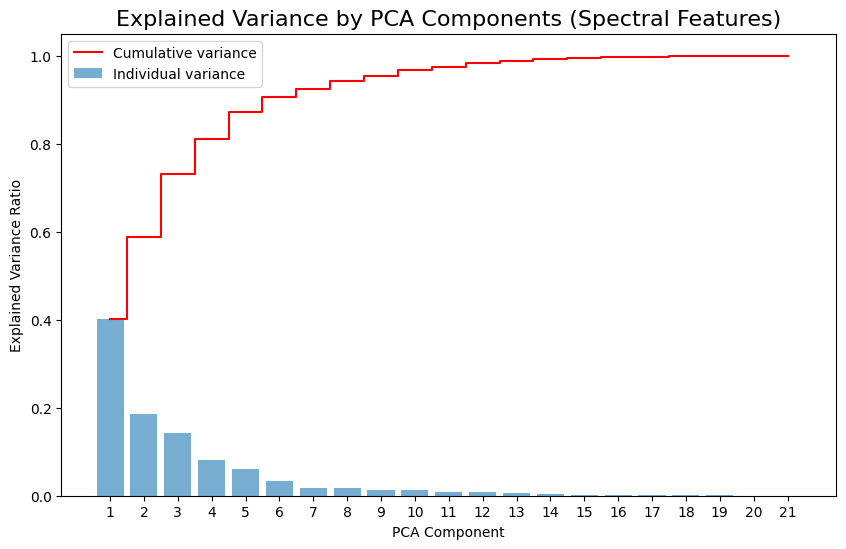

In [51]:
pca_spectral, df_pca_spectral = apply_pca(df_spectral, spectral_features)
plot_pca_correlations(df_spectral, spectral_features, pca_spectral, df_pca_spectral, title="PCA Components vs Original Spectral Features Correlation")
plot_pca_variance(pca_spectral, title="Explained Variance by PCA Components (Spectral Features)")

In [52]:
# We re going to keep the 1st 5 PCA components and remove all spectral original features
n_pca_components = 5
df_spectral_pca = df_spectral.drop(columns=spectral_features)
df_echonest_pca = df_echonest.drop(columns=spectral_features)
for i in range(n_pca_components):
    df_spectral_pca[f'Spec_PC{i+1}'] = df_pca_spectral[f'PC{i+1}']
    df_echonest_pca[f'Spec_PC{i+1}'] = df_pca_spectral[f'PC{i+1}']


print(f"DataFrame shape after adding PCA components: {df_spectral_pca.shape}")
print(f"Dataframe features after adding PCA components: {df_spectral_pca.columns.tolist()}")
print(f"DataFrame shape after adding PCA components: {df_echonest_pca.shape}")
print(f"Dataframe features after adding PCA components: {df_echonest_pca.columns.tolist()}")

DataFrame shape after adding PCA components: (97288, 16)
Dataframe features after adding PCA components: ['album_title', 'album_tracks', 'artist_name', 'duration', 'favorites', 'genre_top', 'genres', 'genres_all', 'interest', 'listens', 'title', 'Spec_PC1', 'Spec_PC2', 'Spec_PC3', 'Spec_PC4', 'Spec_PC5']
DataFrame shape after adding PCA components: (10405, 24)
Dataframe features after adding PCA components: ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'album_title', 'album_tracks', 'artist_name', 'duration', 'favorites', 'genre_top', 'genres', 'genres_all', 'interest', 'listens', 'title', 'Spec_PC1', 'Spec_PC2', 'Spec_PC3', 'Spec_PC4', 'Spec_PC5']


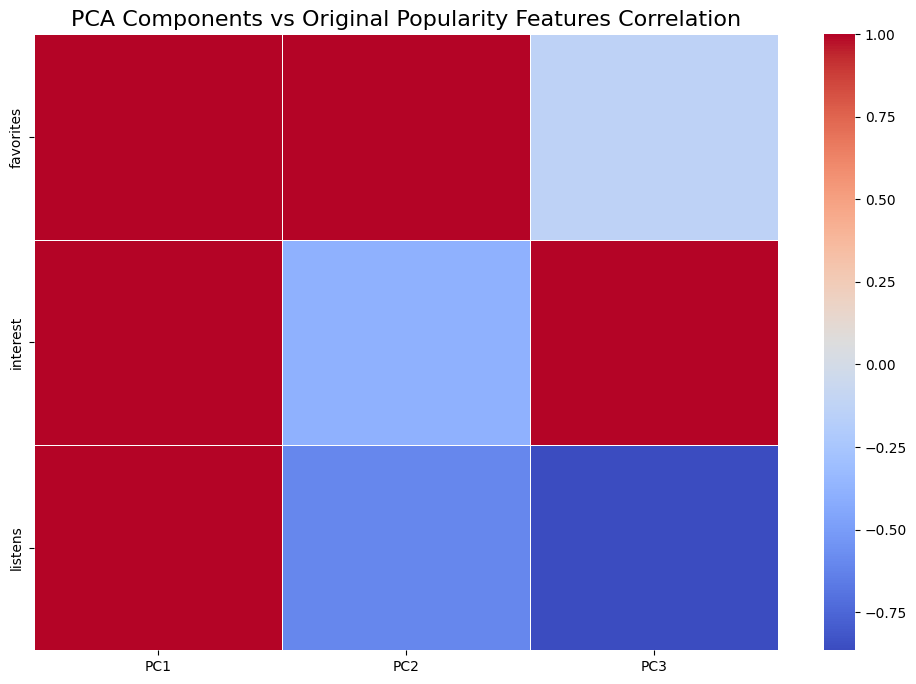

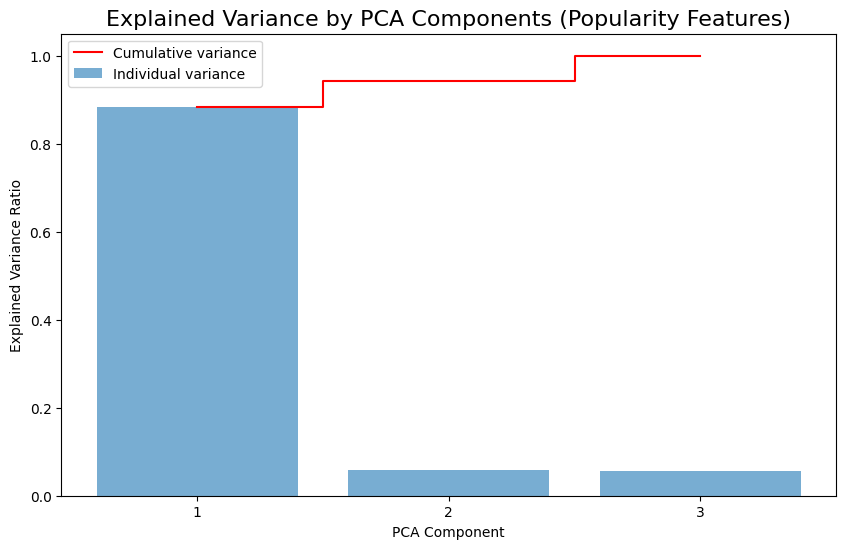

In [53]:
# Apply PCA on popularity features as well 
pca_popularity, df_pca_popularity = apply_pca(df_spectral_pca, popularity_features)
plot_pca_correlations(df_spectral_pca, popularity_features, pca_popularity, df_pca_popularity, title="PCA Components vs Original Popularity Features Correlation")
plot_pca_variance(pca_popularity, title="Explained Variance by PCA Components (Popularity Features)")

In [54]:
# We are going to keep only the 1st pca component from popularity features
# for both datasets
n_popularity_pca_components = 1
df_spectral_final = df_spectral_pca.drop(columns=popularity_features)
df_echonest_final = df_echonest_pca.drop(columns=popularity_features)
for i in range(n_popularity_pca_components):
    df_spectral_final[f'Pop_PC{i+1}'] = df_pca_popularity[f'PC{i+1}']
    df_echonest_final[f'Pop_PC{i+1}'] = df_pca_popularity[f'PC{i+1}']

print(f"DataFrame shape after adding PCA components: {df_spectral_final.shape}")
print(f"Dataframe features after adding PCA components: {df_spectral_final.columns.tolist()}")
print(f"DataFrame shape after adding PCA components: {df_echonest_final.shape}")
print(f"Dataframe features after adding PCA components: {df_echonest_final.columns.tolist()}")

DataFrame shape after adding PCA components: (97288, 14)
Dataframe features after adding PCA components: ['album_title', 'album_tracks', 'artist_name', 'duration', 'genre_top', 'genres', 'genres_all', 'title', 'Spec_PC1', 'Spec_PC2', 'Spec_PC3', 'Spec_PC4', 'Spec_PC5', 'Pop_PC1']
DataFrame shape after adding PCA components: (10405, 22)
Dataframe features after adding PCA components: ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'album_title', 'album_tracks', 'artist_name', 'duration', 'genre_top', 'genres', 'genres_all', 'title', 'Spec_PC1', 'Spec_PC2', 'Spec_PC3', 'Spec_PC4', 'Spec_PC5', 'Pop_PC1']


In [55]:
# We re going to drop genres and genres_all because they re leakage features
# We re dropping them for the preprocessing 
df_spectral_final = df_spectral_final.drop(columns=['genres', 'genres_all'])
df_echonest_final = df_echonest_final.drop(columns=['genres', 'genres_all'])

print(f"Final DataFrame shape (Spectral): {df_spectral_final.shape}")
print(f"Final Dataframe features (Spectral): {df_spectral_final.columns.tolist()}")
print(f"Final DataFrame shape (Echonest): {df_echonest_final.shape}")
print(f"Final Dataframe features (Echonest): {df_echonest_final.columns.tolist()}")

Final DataFrame shape (Spectral): (97288, 12)
Final Dataframe features (Spectral): ['album_title', 'album_tracks', 'artist_name', 'duration', 'genre_top', 'title', 'Spec_PC1', 'Spec_PC2', 'Spec_PC3', 'Spec_PC4', 'Spec_PC5', 'Pop_PC1']
Final DataFrame shape (Echonest): (10405, 20)
Final Dataframe features (Echonest): ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'album_title', 'album_tracks', 'artist_name', 'duration', 'genre_top', 'title', 'Spec_PC1', 'Spec_PC2', 'Spec_PC3', 'Spec_PC4', 'Spec_PC5', 'Pop_PC1']


We re going to try embedding on textual data

In [56]:
# Now we will use embeddings for the text features (artist_name, title, album_name)
text_features = ['artist_name', 'title', 'album_title']

df_embeddings = df_echonest_final.copy()

# Concatenate into one string per track
df_embeddings["text_meta"] = (
    df_embeddings["artist_name"].fillna("") + " - " +
    df_embeddings["title"].fillna("") + " | " +
    df_embeddings["album_title"].fillna("")
)

# Lowercase and strip whitespace
df_embeddings["text_meta"] = df_embeddings["text_meta"].str.lower().str.strip()


In [57]:
model = SentenceTransformer("all-MiniLM-L6-v2")

texts = df_embeddings["text_meta"].tolist()

# Encode in batches
batch_size = 512
all_embeds = []

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i+batch_size]
    batch_embeds = model.encode(batch_texts, show_progress_bar=True, convert_to_numpy=True)
    all_embeds.extend(batch_embeds)

# Now text_embs[i] is the embedding for track i.
text_embs = np.vstack(all_embeds)

Batches: 100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


In [58]:
text_embs.shape  # (num_tracks, embedding_dimension)

(10405, 384)

In [59]:
text_embs_pd = pd.DataFrame(text_embs)
text_embs_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.064493,0.040722,0.019638,0.058853,-0.006592,0.061206,0.003427,-0.121171,-0.011342,0.013000,...,0.029383,-0.045956,-0.072811,0.087778,-0.038365,0.023333,0.103026,0.025474,0.043048,0.013123
1,0.047659,-0.005769,0.015794,0.067692,-0.011705,0.033822,0.021273,-0.135541,-0.001400,0.008527,...,-0.002746,-0.055737,-0.060171,0.070429,-0.004351,0.031436,0.095005,0.025266,0.070416,0.039543
2,0.082888,0.034695,-0.001763,0.010147,-0.053025,0.041640,-0.058108,-0.084850,-0.037530,-0.009622,...,-0.006076,-0.030518,0.016997,0.037393,0.045892,0.019554,0.095097,-0.005180,0.043385,0.016198
3,0.009422,-0.023726,0.018944,0.025754,-0.008091,0.053894,-0.002441,-0.059583,-0.019687,-0.016590,...,0.012782,0.023717,-0.023621,-0.001498,-0.047580,0.023265,0.073796,0.013045,-0.000760,0.032979
4,0.007854,-0.054865,0.030726,0.012789,-0.000792,0.069638,0.029039,-0.096973,-0.028759,-0.024760,...,0.052589,0.003238,-0.097681,0.056844,-0.052756,-0.001094,0.123207,0.017641,-0.030052,0.029991


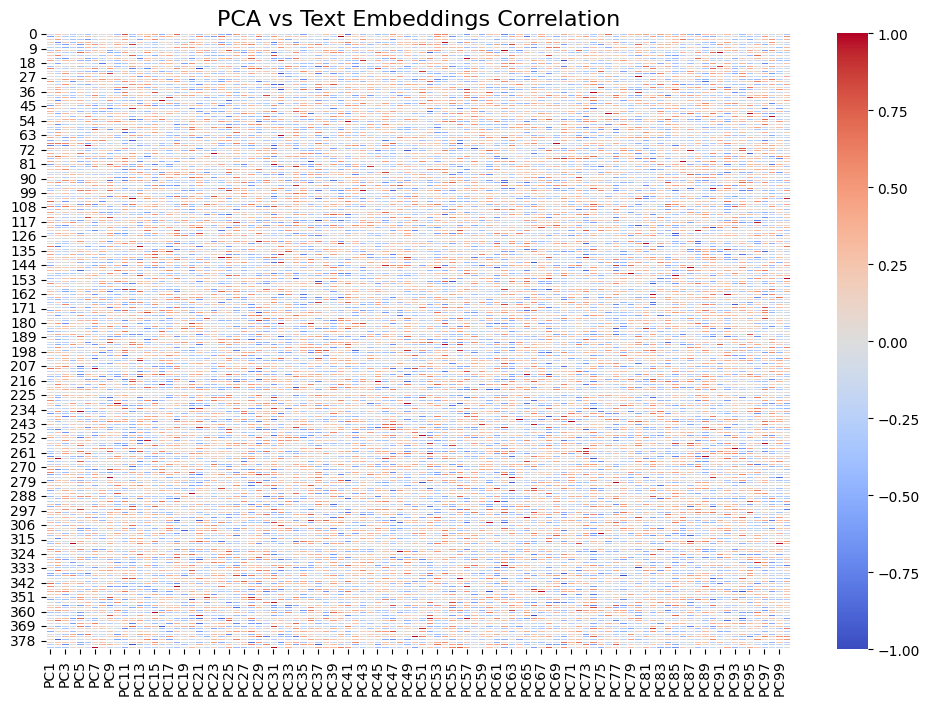

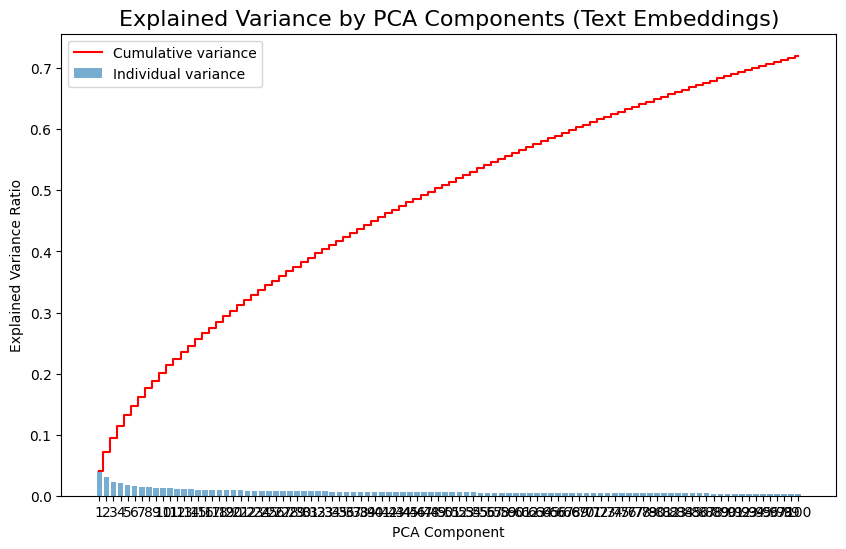

In [60]:
# Apply PCA on text embeddings to reduce dimensionality and plot correlations
pca_text, df_pca_text = apply_pca(pd.DataFrame(text_embs), list(range(text_embs.shape[1])), n_components=100)
plot_pca_correlations(pd.DataFrame(text_embs), list(range(text_embs.shape[1])), pca_text, df_pca_text, title="PCA vs Text Embeddings Correlation")
plot_pca_variance(pca_text, title="Explained Variance by PCA Components (Text Embeddings)")

We noticed that we need + 100 feature to have an embedding of the artist and track textual features, which is not helpful, therefore we're going to drop thse feature 

In [61]:
# Drop original text features from df_spectral_final
df_spectral_final = df_spectral_final.drop(columns=text_features)
df_echonest_final = df_echonest_final.drop(columns=text_features)

print(f"Final DataFrame shape (Spectral): {df_spectral_final.shape}")
print(f"Final Dataframe features (Spectral): {df_spectral_final.columns.tolist()}")
print(f"Final DataFrame shape (Echonest): {df_echonest_final.shape}")
print(f"Final Dataframe features (Echonest): {df_echonest_final.columns.tolist()}")

Final DataFrame shape (Spectral): (97288, 9)
Final Dataframe features (Spectral): ['album_tracks', 'duration', 'genre_top', 'Spec_PC1', 'Spec_PC2', 'Spec_PC3', 'Spec_PC4', 'Spec_PC5', 'Pop_PC1']
Final DataFrame shape (Echonest): (10405, 17)
Final Dataframe features (Echonest): ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'album_tracks', 'duration', 'genre_top', 'Spec_PC1', 'Spec_PC2', 'Spec_PC3', 'Spec_PC4', 'Spec_PC5', 'Pop_PC1']


The clustering (K-means)

In [62]:
# Drop genre_top for clustering
df_spectral_num = df_spectral_final.drop(columns=['genre_top'])
df_echonest_num = df_echonest_final.drop(columns=['genre_top'])

Approach 1 : [Bad clustering n1]

In [63]:
# (97288, 9)
# ['album_tracks', 'duration', 'genre_top', 'Spec_PC1', 'Spec_PC2', 'Spec_PC3', 'Spec_PC4', 'Spec_PC5', 'Pop_PC1']
# (10405, 17)
# ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'album_tracks', 'duration', 'genre_top', 'Spec_PC1', 'Spec_PC2', 'Spec_PC3', 'Spec_PC4', 'Spec_PC5', 'Pop_PC1']

# We re going to use encoder features for the echonest dataset to reduce dimensionality
encoder_features = ['acousticness', 'danceability', 'energy', 'instrumentalness',
    'liveness', 'speechiness', 'tempo', 'valence',
    'album_tracks', 'duration',
    'Spec_PC1', 'Spec_PC2', 'Spec_PC3', 'Spec_PC4', 'Spec_PC5',
    'Pop_PC1']

X = df_echonest_num[encoder_features].values

# Standarize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
input_dim = X_scaled.shape[1]

In [64]:
# Hyperparameters
encoding_dim = 10
hidden_dim = 24
epochs = 30
batch_size = 256

# encoder
input_layer = layers.Input(shape=(input_dim,))

h = layers.Dense(hidden_dim, activation='relu')(input_layer)

botteleneck = layers.Dense(encoding_dim, activation='relu')(h)

# decoder
h_dec = layers.Dense(hidden_dim, activation='relu')(botteleneck)
output_layer = layers.Dense(input_dim, activation='linear')(h_dec)
# autoencoder models
autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Train
history = autoencoder.fit(X_scaled, X_scaled,
                          epochs=epochs,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_split=0.1,
                          verbose=1)

Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0175 - val_loss: 0.8194
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9324 - val_loss: 0.7594
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8337 - val_loss: 0.6808
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7205 - val_loss: 0.5951
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6193 - val_loss: 0.5317
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5484 - val_loss: 0.4755
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4954 - val_loss: 0.4301
Epoch 8/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4468 - val_loss: 0.3813
Epoch 9/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4042 - val_loss: 0.3473
Epoch 10/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3685 - val_loss: 0.3159
Epoch 11/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3457 - val_loss: 0.3035
Epoch 12/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3270 - val_lo

In [65]:
encoder = models.Model(inputs=input_layer, outputs=botteleneck)

# Get the encoded representations
Z = encoder.predict(X_scaled, batch_size=batch_size)
z_scaler = StandardScaler()
Z_scaled = z_scaler.fit_transform(Z)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [66]:
# We rou going to run kmeans on latent space and assign cluster labels
# 1st we try out 3 clusters
k = 3
k_means_ae = KMeans(n_clusters=k, random_state=42)
cluster_labels_ae = k_means_ae.fit_predict(Z_scaled)

df_echonest_ae = df_echonest_final.copy()
df_echonest_ae['cluster_ae'] = cluster_labels_ae

# See which fine genres fall in which AE-cluster
ct = pd.crosstab(df_echonest_ae['cluster_ae'], df_echonest_ae['genre_top'])
ct

genre_top,Blues,Classical,Easy Listening,Electronic,Experimental,Folk,Hip-Hop,Instrumental,International,Jazz,Pop,Rock
cluster_ae,,,,,,,,,,,,
0,59,110,12,1049,22,371,430,50,69,149,335,1162
1,101,156,43,1636,29,777,303,61,181,283,660,1743
2,4,37,3,163,2,64,170,8,19,14,31,99


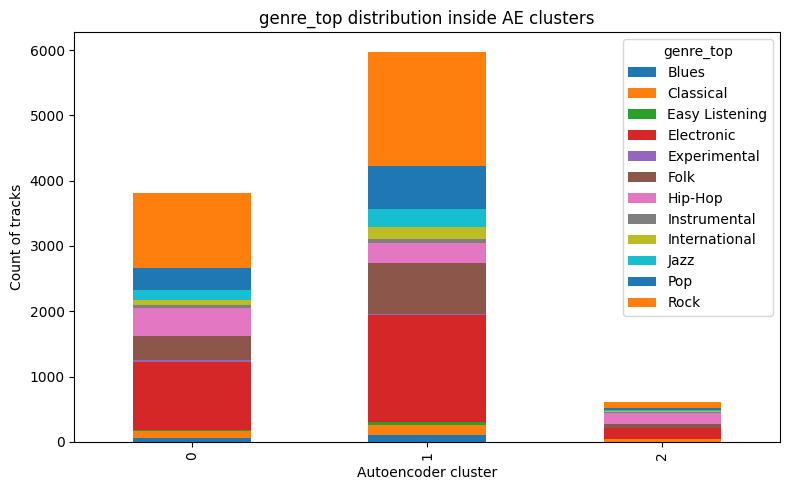

In [67]:
ct.plot(kind='bar', stacked=True, figsize=(8,5))
plt.xlabel('Autoencoder cluster')
plt.ylabel('Count of tracks')
plt.title('genre_top distribution inside AE clusters')
plt.tight_layout()
plt.show()


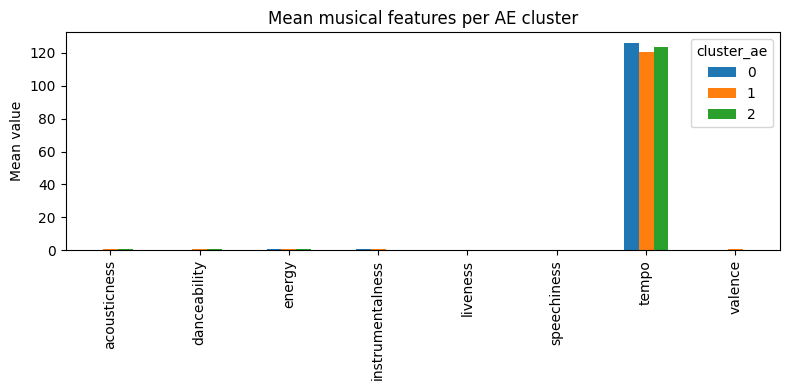

In [68]:
# 1) Mean feature per cluster
mean_by_cluster = df_echonest_ae.groupby('cluster_ae')[
    ['acousticness','danceability','energy','instrumentalness',
     'liveness','speechiness','tempo','valence']
].mean()

mean_by_cluster.T.plot(kind='bar', figsize=(8,4))
plt.ylabel('Mean value')
plt.title('Mean musical features per AE cluster')
plt.tight_layout()
plt.show()


Approach 2 : Clustering without autoencoding [bad approach]

In [69]:
df_echonest_final.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,album_tracks,duration,genre_top,Spec_PC1,Spec_PC2,Spec_PC3,Spec_PC4,Spec_PC5,Pop_PC1
0,0.373039,0.429892,0.645929,0.769285,0.195042,0.101240,159.908,0.474554,10,131,Hip-Hop,0.118641,1.163968,-0.037856,0.976482,0.449219,-0.373249
1,0.908215,0.427918,0.694364,0.950413,0.269082,0.180927,188.077,0.585049,10,185,Hip-Hop,0.196037,-0.143670,-0.278785,0.588802,0.068307,-0.369163
2,0.204111,0.501329,0.608690,0.725811,0.125451,0.623711,137.676,0.522381,10,183,Hip-Hop,1.123142,0.154781,-0.490849,-0.376471,-0.140204,-0.372563
3,0.464478,0.419687,0.743163,0.786033,0.214622,0.142762,79.371,0.644394,10,213,Hip-Hop,0.707095,-0.136350,-0.154662,0.554418,-0.467090,-0.241591
4,0.921960,0.350383,0.588584,0.861204,0.120561,0.187306,190.518,0.537996,10,162,Hip-Hop,0.450496,-1.025226,0.646793,1.410960,-0.149837,-0.371245


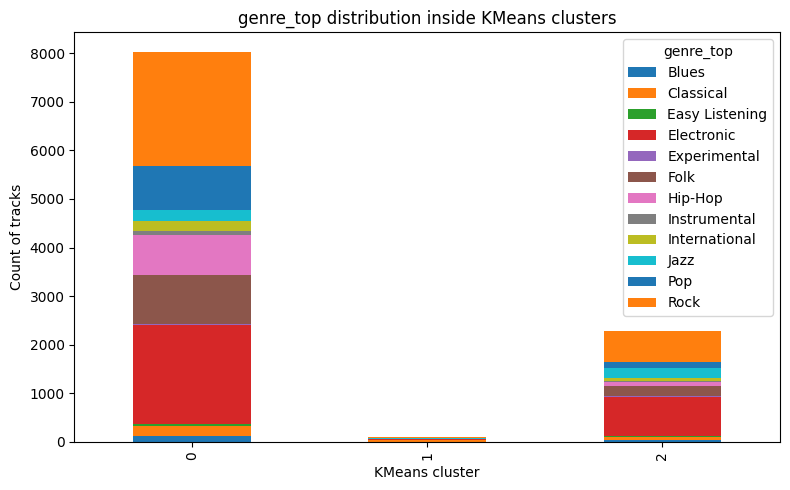

In [70]:
# We re going to try not encoding echonest features and use all features in the dataset
df_echonest_kmeans = df_echonest_final.copy()
X = df_echonest_kmeans.drop(columns=['genre_top']).values

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X)


df_echonest_kmeans['cluster_kmeans'] = cluster_labels

# See which fine genres fall in which KMeans-cluster
ct_kmeans = pd.crosstab(df_echonest_kmeans['cluster_kmeans'], df_echonest_kmeans['genre_top'])
ct_kmeans.plot(kind='bar', stacked=True, figsize=(8,5))
plt.xlabel('KMeans cluster')
plt.ylabel('Count of tracks')
plt.title('genre_top distribution inside KMeans clusters')
plt.tight_layout()
plt.show()

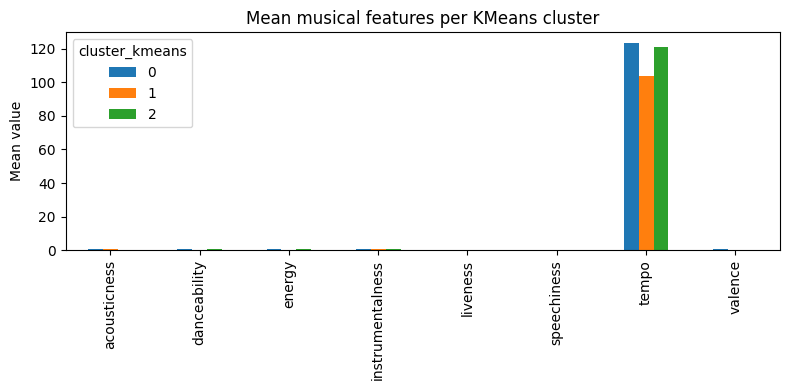

In [71]:
# 1) Mean feature per cluster
mean_by_cluster = df_echonest_kmeans.groupby('cluster_kmeans')[
    ['acousticness','danceability','energy','instrumentalness',
     'liveness','speechiness','tempo','valence']
].mean()

mean_by_cluster.T.plot(kind='bar', figsize=(8,4))
plt.ylabel('Mean value')
plt.title('Mean musical features per KMeans cluster')
plt.tight_layout()
plt.show()

Approach 3 : transform lines into genres instead of tracks

In [72]:
num_cols = [
    'acousticness','danceability','energy','instrumentalness',
    'liveness','speechiness','tempo','valence',
    'album_tracks','duration',
    'Spec_PC1','Spec_PC2','Spec_PC3','Spec_PC4','Spec_PC5',
    'Pop_PC1'
]

# Compute mean features per genre_top
genre_df = df_echonest_final.groupby('genre_top')[num_cols].median().reset_index()

# 4) 25th percentile per genre
# genre_df = df_echonest_final.groupby('genre_top')[num_cols].quantile(0.25).reset_index()

# remove the features with low variance
var_series = genre_df[num_cols].var()   # variance of each column

print(var_series.sort_values())


liveness              0.000057
Pop_PC1               0.001010
speechiness           0.001271
danceability          0.010501
Spec_PC5              0.015487
Spec_PC3              0.016149
valence               0.025924
energy                0.032630
Spec_PC4              0.038216
Spec_PC2              0.047736
acousticness          0.067746
instrumentalness      0.089786
Spec_PC1              0.305490
album_tracks         20.628788
tempo                74.100680
duration            736.992424
dtype: float64


In [73]:
selector = VarianceThreshold(threshold=0.01)  # choose threshold
X_lowvar = selector.fit_transform(genre_df[num_cols])

# Get kept column names
kept_cols = genre_df[num_cols].columns[selector.get_support()]

# print kept columns
print("Kept columns after low variance removal:")
for col in kept_cols:
    print(col)

Kept columns after low variance removal:
acousticness
energy
instrumentalness
tempo
valence
album_tracks
duration
Spec_PC1
Spec_PC2
Spec_PC3
Spec_PC4
Spec_PC5


In [74]:

# Separate key and features
Xg = genre_df[kept_cols].values

scaler_g = StandardScaler()
Xg_scaled = scaler_g.fit_transform(Xg)

kmeans_genre = KMeans(n_clusters=4, random_state=42)
genre_cluster_labels = kmeans_genre.fit_predict(Xg_scaled)

genre_df['genre_cluster'] = genre_cluster_labels


In [75]:
genre_df.head()

,genre_top,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,album_tracks,duration,Spec_PC1,Spec_PC2,Spec_PC3,Spec_PC4,Spec_PC5,Pop_PC1,genre_cluster
0,Blues,0.797929,0.530396,0.408815,0.083035,0.123691,0.040514,111.4770,0.554266,10.0,232.5,0.138550,-0.316360,-0.452661,-0.022216,-0.093704,-0.273824,2
1,Classical,0.993000,0.326449,0.054979,0.899458,0.115801,0.046699,96.2100,0.172912,16.0,211.0,0.749898,-0.040486,-0.102062,-0.303287,-0.196854,-0.247017,0
2,Easy Listening,0.723953,0.591393,0.502951,0.867415,0.108289,0.052036,113.2605,0.420312,21.0,195.5,-0.848339,-0.602880,-0.327029,0.244039,-0.268333,-0.211892,1
3,Electronic,0.174973,0.628130,0.645337,0.863792,0.112875,0.062551,122.8650,0.440494,11.0,234.5,0.179839,-0.136229,-0.217867,-0.050462,-0.175179,-0.281949,1
4,Experimental,0.863719,0.368907,0.286872,0.839526,0.114213,0.046528,108.0120,0.141975,11.0,238.0,1.503639,0.004996,-0.017093,-0.486920,-0.593166,-0.341985,0


In [76]:
# Which genres in each cluster?
for c in sorted(genre_df['genre_cluster'].unique()):
    print(f"\nCluster {c}:")
    print(genre_df.loc[genre_df['genre_cluster'] == c, 'genre_top'].tolist())



Cluster 0:
['Classical', 'Experimental']

Cluster 1:
['Easy Listening', 'Electronic', 'Folk', 'Hip-Hop', 'International', 'Pop', 'Rock']

Cluster 2:
['Blues', 'Jazz']

Cluster 3:
['Instrumental']


The current clustering is the best, we can adjust it a bit and make it into :


Group A – Mainstream & Beat‑driven
    Electronic, Hip-Hop, Pop, Rock, International
    (high/medium energy, more rhythmic)

Group B – Jazz/Blues/Instrumental/Easy listening
    Jazz, Blues, Instrumental, Easy Listening
    (smoother, more “listening” than “dancing”, often mid‑tempo)

Group C – Acoustic/Art/Niche
    Classical, Folk, Experimental
    (more acoustic, often lower tempo or non‑beat‑driven)



In [77]:
c1 = ['Electronic', 'Hip-Hop', 'Pop', 'Rock', 'International']
c2 = ['Jazz', 'Blues', 'Instrumental', 'Easy Listening']
c3 = ['Classical', 'Folk', 'Experimental']



Prediction using the echonest dataset

In [80]:
# Choose numeric columns
# group by c1, c2, c3 groups

df_echonest_coarse = df_echonest_final.copy()
df_echonest_coarse['genre_top'] = df_echonest_final['genre_top'].apply(
    lambda g: 'c1' if g in c1 else ('c2' if g in c2 else 'c3')
)

print(df_echonest_coarse['genre_top'].value_counts())

# df = df_echonest_final.dropna(subset=num_cols + ['genre_top']).copy()

X = df_echonest_coarse[num_cols].values
y = df_echonest_coarse['genre_top'].values

# 2) Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)   # integers 0..K-1

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)


genre_top
c1    8050
c3    1568
c2     787
Name: count, dtype: int64


In [81]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,       # number of trees
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',   # multi-class
    num_class=len(le.classes_),   # number of genres
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [82]:
y_pred = xgb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

print(classification_report(
    y_test, y_pred,
    target_names=le.classes_
))


Accuracy: 0.857760691975012
              precision    recall  f1-score   support

          c1       0.88      0.97      0.92      1610
          c2       0.68      0.16      0.26       157
          c3       0.75      0.62      0.68       314

    accuracy                           0.86      2081
   macro avg       0.77      0.58      0.62      2081
weighted avg       0.84      0.86      0.84      2081



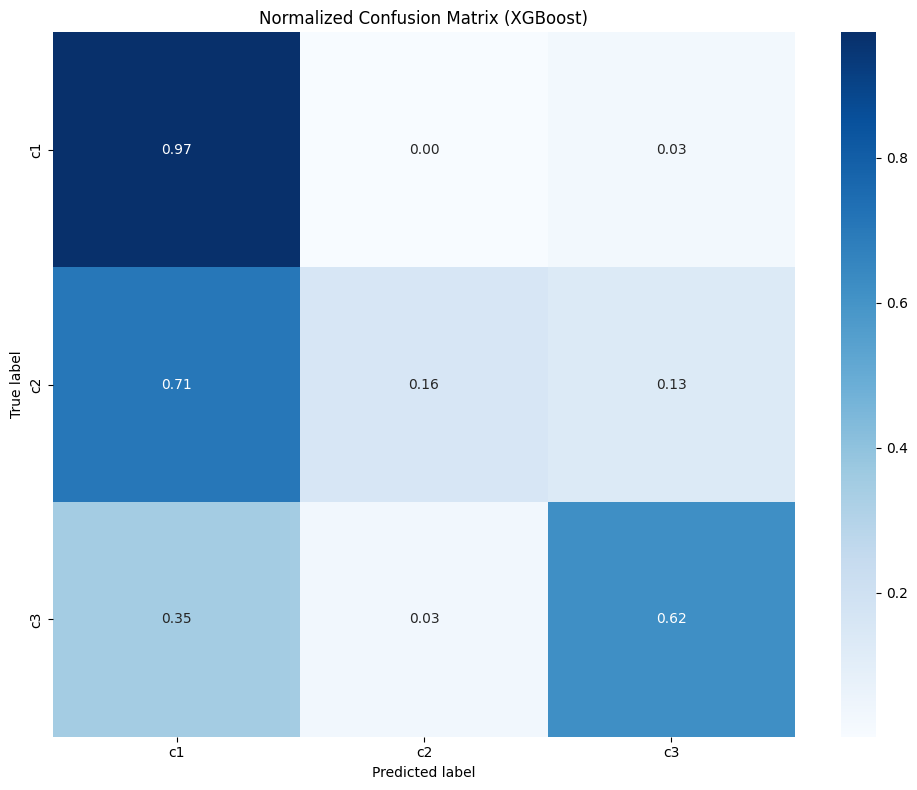

In [83]:
# Visualize performance with a normalized confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Normalized Confusion Matrix (XGBoost)')
plt.tight_layout()
plt.show()



Overall accuracy ≈ 0.85
85% of tracks’ coarse groups are predicted correctly.

c1 (Electronic/Hip-Hop/Pop/Rock/International)

    Precision 0.87: when model predicts c1, it’s usually right.

    Recall 0.97: it finds almost all true c1 tracks.

    F1 0.92: excellent.
    → Model is very good at recognizing “mainstream/beat‑driven” tracks.

c2 (Jazz/Blues/Instrumental/Easy Listening)

    Precision 0.71: if it predicts c2, it’s often correct.

    Recall 0.14: but it rarely predicts c2 at all.

    F1 0.23: poor.
    → Many true c2 tracks are misclassified as c1 or c3. This is the main weakness.

c3 (Classical/Folk/Experimental)

    Precision 0.75, recall 0.59, F1 0.66: reasonable but not as good as c1.



We re going to try to weight the c2 class because it is the most underpresented in the dataset

In [84]:
# if we use the by-default class weights from sklearn
# didn't perform well
# classes = np.unique(y_enc)          # encoded 0,1,2 for c1,c2,c3
# cw = compute_class_weight('balanced', classes=classes, y=y_enc)
# class_weights = dict(zip(classes, cw))

# # build sample weights vector for each training example
# w_train = np.array([class_weights[c] for c in y_train])
# print(class_weights)  

for w_c2 in [3.0, 5.0, 10.0]:
    class_weights = {0: 1.0, 1: w_c2, 2: 1.5}
    w_train = np.array([class_weights[c] for c in y_train])

    xgb.fit(X_train, y_train, sample_weight=w_train)
    y_pred = xgb.predict(X_test)

    print(f"\n=== c2 weight = {w_c2} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=le.classes_))


=== c2 weight = 3.0 ===
Accuracy: 0.8558385391638635
              precision    recall  f1-score   support

          c1       0.88      0.96      0.92      1610
          c2       0.62      0.24      0.35       157
          c3       0.72      0.62      0.67       314

    accuracy                           0.86      2081
   macro avg       0.74      0.61      0.65      2081
weighted avg       0.84      0.86      0.84      2081


=== c2 weight = 5.0 ===
Accuracy: 0.8529553099471407
              precision    recall  f1-score   support

          c1       0.89      0.96      0.92      1610
          c2       0.51      0.28      0.36       157
          c3       0.75      0.61      0.67       314

    accuracy                           0.85      2081
   macro avg       0.72      0.62      0.65      2081
weighted avg       0.84      0.85      0.84      2081


=== c2 weight = 10.0 ===
Accuracy: 0.8452666987025469
              precision    recall  f1-score   support

          c1       0

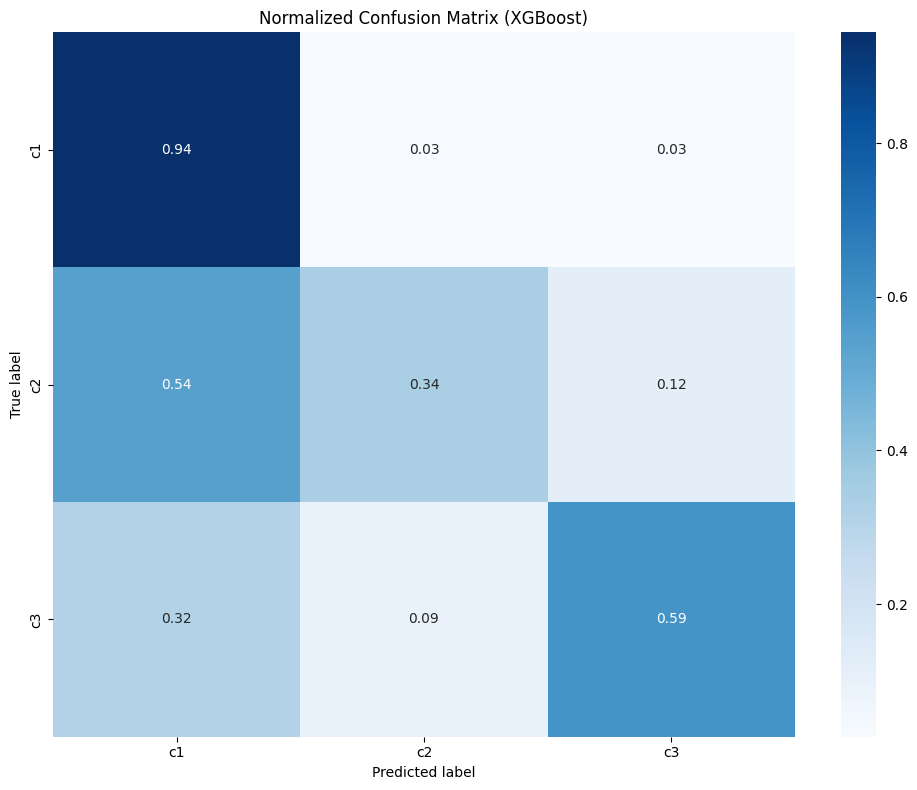

In [85]:
# Visualize performance with a normalized confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Normalized Confusion Matrix (XGBoost)')
plt.tight_layout()
plt.show()

We re going to try Random forests now and keeping the weighted classes

In [86]:
from sklearn.ensemble import RandomForestClassifier

xrf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight=class_weights,   # help c2 again
    random_state=42,
    n_jobs=-1
)

xrf.fit(X_train, y_train)
y_pred = xrf.predict(X_test)

print("RF accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

RF accuracy: 0.8443056222969726
              precision    recall  f1-score   support

          c1       0.86      0.98      0.91      1610
          c2       0.64      0.09      0.16       157
          c3       0.77      0.54      0.63       314

    accuracy                           0.84      2081
   macro avg       0.75      0.54      0.57      2081
weighted avg       0.83      0.84      0.81      2081



Even with class rebalancing, Random Forest strongly favors the majority class, while XGBoost handles the minority c2 group better, giving a higher macro‑F1. Therefore XGBoost is the preferred model for coarse‑genre prediction.

We are going to use Logistic Regression this time

In [87]:
from sklearn.linear_model import LogisticRegression

# X, y_enc, X_train, X_test, y_train, y_test as before 
log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    class_weight=class_weights,   # auto‑upweights c2
    max_iter=1000,
    n_jobs=-1
)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print("LogReg accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))


c:\Users\Chaima\Documents_local\3A\Supervised_Challenge\supervised_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogReg accuracy: 0.6448822681403171
              precision    recall  f1-score   support

          c1       0.93      0.73      0.82      1610
          c2       0.14      0.66      0.23       157
          c3       0.80      0.21      0.33       314

    accuracy                           0.64      2081
   macro avg       0.62      0.53      0.46      2081
weighted avg       0.85      0.64      0.70      2081



LogReg is too aggressive on c2—many false positives, hurting overall performance and c3 badly. XGBoost is clearly the better compromise: higher macro‑F1 and much higher accuracy, with reasonably good c2.

Approach 3 : transform lines into genres instead of tracks (fot Spectral Features DataSet)

In [88]:
# we omit 'genre_top' since it's categorical
num_cols_spec = ['album_tracks', 'duration', 'Spec_PC1', 'Spec_PC2', 'Spec_PC3', 'Spec_PC4', 'Spec_PC5', 'Pop_PC1']

# Aggregate spectral features per genre using median
genre_df_spec = df_spectral_final.groupby('genre_top')[num_cols_spec].median().reset_index()

# If you used quantiles instead of median:
# genre_df = df_spectral_final.groupby('genre_top')[num_cols].quantile(0.25).reset_index()

#Remove low-variance spectral features 
var_series_spec = genre_df_spec[num_cols_spec].var()
print(var_series_spec.sort_values())

selector = VarianceThreshold(threshold=0.01)
X_lowvar_spec = selector.fit_transform(genre_df_spec[num_cols_spec])

kept_cols_spec = genre_df_spec[num_cols_spec].columns[selector.get_support()]

print("Kept columns after low variance removal:")
for col in kept_cols_spec:
    print(col)



Spec_PC3           0.011358
Pop_PC1            0.033094
Spec_PC5           0.044213
Spec_PC4           0.101341
Spec_PC2           0.150308
Spec_PC1           1.523238
album_tracks       2.379121
duration        3041.199176
dtype: float64
Kept columns after low variance removal:
album_tracks
duration
Spec_PC1
Spec_PC2
Spec_PC3
Spec_PC4
Spec_PC5
Pop_PC1


In [89]:
# Scaling + KMeans clustering 
Xg_spec = genre_df_spec[kept_cols_spec].values

Xg_scaled_spec = scaler_g.fit_transform(Xg_spec)

genre_cluster_labels_spec = kmeans_genre.fit_predict(Xg_scaled_spec)

genre_df_spec['genre_cluster'] = genre_cluster_labels_spec

genre_df_spec.head()

,genre_top,album_tracks,duration,Spec_PC1,Spec_PC2,Spec_PC3,Spec_PC4,Spec_PC5,Pop_PC1,genre_cluster
0,Blues,10.0,229.0,0.323857,-0.353338,-0.312840,-0.020434,-0.140962,0.057211,3
1,Classical,14.0,190.5,-2.937884,-0.617172,0.011339,0.077011,-0.204056,0.178446,2
2,Easy Listening,11.0,224.0,-1.692197,-0.712778,-0.314865,0.141153,0.069603,0.152453,3
3,Electronic,11.0,235.0,1.008415,-0.738047,-0.164181,-0.106035,0.230774,-0.202411,3
4,Experimental,12.0,260.0,-0.388875,-0.378613,-0.202516,0.052829,-0.115598,-0.333410,0


In [90]:
# Print genres per cluster 
for c in sorted(genre_df_spec['genre_cluster'].unique()):
    print(f"\nCluster {c}:")
    print(genre_df_spec.loc[genre_df_spec['genre_cluster'] == c, 'genre_top'].tolist())


Cluster 0:
['Experimental', 'Folk', 'Hip-Hop', 'International', 'Pop', 'Rock', 'Spoken']

Cluster 1:
['Holiday']

Cluster 2:
['Classical']

Cluster 3:
['Blues', 'Easy Listening', 'Electronic', 'Instrumental', 'Jazz']
